## Part 1: Pulse Rate Algorithm

### Contents
Fill out this notebook as part of your final project submission.

**You will have to complete both the Code and Project Write-up sections.**
- The [Code](#Code) is where you will write a **pulse rate algorithm** and already includes the starter code.
   - Imports - These are the imports needed for Part 1 of the final project. 
     - [glob](https://docs.python.org/3/library/glob.html)
     - [numpy](https://numpy.org/)
     - [scipy](https://www.scipy.org/)
- The [Project Write-up](#Project-Write-up) to describe why you wrote the algorithm for the specific case.


### Dataset
You will be using the **Troika**[1] dataset to build your algorithm. Find the dataset under `datasets/troika/training_data`. The `README` in that folder will tell you how to interpret the data. The starter code contains a function to help load these files.

1. Zhilin Zhang, Zhouyue Pi, Benyuan Liu, ‘‘TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise,’’IEEE Trans. on Biomedical Engineering, vol. 62, no. 2, pp. 522-531, February 2015. Link

-----

In [1]:
import glob
import numpy as np
import scipy as sp
import scipy.signal
import scipy.io
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams.update({'font.size': 16})

# Sampling frequency of the signal in Hz
fs = 125

# Rolling window length and overlap values as in ground truth
window_len = 8
window_overlap = 6

# Setting restriction to pulse rate to be between 40BPM and 240BPM [in Hz]
freq_min = 40/60
freq_max = 240/60


def LoadTroikaDataset():
    """
    Retrieve the .mat filenames for the troika dataset.

    Review the README in ./datasets/troika/ to understand the organization of the .mat files.

    Returns:
        data_fls: Names of the .mat files that contain signal data
        ref_fls: Names of the .mat files that contain reference data
        <data_fls> and <ref_fls> are ordered correspondingly, so that ref_fls[5] is the 
            reference data for data_fls[5], etc...
    """
    data_dir = "./datasets/troika/training_data"
    data_fls = sorted(glob.glob(data_dir + "/DATA_*.mat"))
    ref_fls = sorted(glob.glob(data_dir + "/REF_*.mat"))
    return data_fls, ref_fls


def LoadTroikaDataFile(data_fl):
    """
    Loads and extracts PPG sensor and 3-axis ACC sensor signals from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ppg, accx, accy, accz = LoadTroikaDataFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat data file.

    Returns:
        numpy arrays for ppg, accx, accy, accz signals.
    """
    data = sp.io.loadmat(data_fl)['sig']
    return data[2:]


def LoadTroikaEKGFile(data_fl): 
    """
    Loads EKG signal from a troika data file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        ekg = LoadTroikaEKGFile(data_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy array for EKG signal.
    """
    ekg = sp.io.loadmat(data_fl)['sig']
    return ekg[0:1][0]


def LoadTroikaRefFile(ref_fl):
    """
    Loads heart rate ground truth from a troika reference file.

    Usage:
        data_fls, ref_fls = LoadTroikaDataset()
        heart_rate_GT = (ref_fls[0])

    Args:
        data_fl: (str) filepath to a troika .mat file.

    Returns:
        numpy array for the heart rate ground truth signal.
    """
    heart_rate_GT = sp.io.loadmat(ref_fl)['BPM0']
    return heart_rate_GT


def AggragateAccSignals(accx, accy, accz):
    """
    Aggragates 3-axis accelerometer signals in one magnitude signal.

    Args:
        accx, accy, accz: (numpy array) 3 arrays containing corresponding accelerometer signals.

    Returns:
        numpy array for the aggregated signal.
    """
    
    acc_mag = np.sqrt(np.square(accx) + np.square(accy) + np.square(accz))
    return acc_mag


def ReadPlotDataSignals(data_fl, plot_range=(0, 288)):
    """
    Reads PPG, accelerometer and EKG signals from a troika data file. 
    Aggregates accelerometer signal.
    Plots all the signals within a specified time range.

    Args:
        data_fl: (str) filepath to a troika .mat file.
        plot range: (tuple of int) t_min and t_max of time axis. 

    Returns:
        numpy arrays for PPG, accelerometer (accx, accy, accz) and EKG signals.
    """ 
    
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    ekg = LoadTroikaEKGFile(data_fl)
    
    ts = np.arange(0, len(ppg)/fs, 1/fs)
    acc_mag = AggragateAccSignals(accx, accy, accz)
    
    plt.figure(figsize=(16,20))
    plt.subplot(6,1,1)
    plt.xlim(plot_range)
    plt.plot(ts, ppg, 'black', label='PPG')
    plt.legend(loc=2)
    plt.subplot(6,1,2)
    plt.plot(ts, accx, 'red', label='ACC_X')
    plt.xlim(plot_range)
    plt.legend(loc=2)
    plt.subplot(6,1,3)
    plt.plot(ts, accy, 'green', label='ACC_Y')
    plt.xlim(plot_range)
    plt.legend(loc=2)
    plt.subplot(6,1,4)
    plt.plot(ts, accz, 'blue', label='ACC_Z')
    plt.xlim(plot_range)
    plt.legend(loc=2)
    plt.subplot(6,1,5)
    plt.plot(ts, acc_mag, 'magenta', label='ACC_MAG')
    plt.xlim(plot_range)
    plt.legend(loc=2)
    plt.subplot(6,1,6)
    plt.plot(ts, ekg, 'brown', label='EKG')
    plt.xlim(plot_range)
    plt.legend(loc=2)
    plt.xlabel('Time [s]')
    plt.show()
    
    return ppg, accx, accy, accz, ekg

        
def ReadPlotHeartRateGT(ref_fl):
    """
    Reads heart rate ground truth from a troika reference file and plots it.
    
    Args:
        ref_fl: (str) filepath to a troika .mat file. 

    Returns:
        numpy array for heart rate ground truth.
    """ 
    heart_rate_GT = LoadTroikaRefFile(ref_fl)
    ts = np.arange(0, len(heart_rate_GT))
    
    plt.figure(figsize=(16,4))
    plt.plot(ts, heart_rate_GT, '.', color='black', label='Ref. Heart Rate')
    plt.xlim(0, len(heart_rate_GT))
    plt.xlabel('# of rolling window')
    plt.ylabel('Heart rate [BPM]')
    plt.legend()
    
    return heart_rate_GT
    
    
def AggregateErrorMetric(pr_errors, confidence_est):
    """
    Computes an aggregate error metric based on confidence estimates.

    Computes the MAE at 90% availability. 

    Args:
        pr_errors: a numpy array of errors between pulse rate estimates and corresponding 
            reference heart rates.
        confidence_est: a numpy array of confidence estimates for each pulse rate
            error.

    Returns:
        the MAE at 90% availability
    """
    # Higher confidence means a better estimate. The best 90% of the estimates
    #    are above the 10th percentile confidence.
    percentile90_confidence = np.percentile(confidence_est, 10)

    # Find the errors of the best pulse rate estimates
    best_estimates = pr_errors[confidence_est >= percentile90_confidence]

    # Return the mean absolute error
    return np.mean(np.abs(best_estimates))


def Evaluate():
    """
    Top-level function evaluation function.

    Runs the pulse rate algorithm on the Troika dataset and returns an aggregate error metric.

    Returns:
        Pulse rate error on the Troika dataset. See AggregateErrorMetric.
    """
    # Retrieve dataset files
    data_fls, ref_fls = LoadTroikaDataset()
    errs, confs = [], []
    for data_fl, ref_fl in zip(data_fls, ref_fls):
        # Run the pulse rate algorithm on each trial in the dataset
        errors, confidence = RunPulseRateAlgorithm(data_fl, ref_fl)
        errs.append(errors)
        confs.append(confidence)
        print(f'Evaluating: {data_fl}')
        # Compute aggregate error metric
    errs = np.hstack(errs)
    confs = np.hstack(confs)
    return AggregateErrorMetric(errs, confs)


def BandpassFilter(signal):
    """
    Bandpass filter the signal between 0.67 and 4 Hz (corresponding to 40 and 240 BPM).
    
    Args:
        signal: a numpy array containing the signal

    Returns:
        sp.signal.filtfilt(b, a, signal): a numpy array with the filtered signal.
    """
    
    b, a = sp.signal.butter(3, (freq_min, freq_max), btype='bandpass', fs=fs)
    return sp.signal.filtfilt(b, a, signal)


def ComputePlotSpectrograms(ppg, acc_mag):
    """
    Computes and plots spectograms for raw and filtered data (with the use of the bandpass filter) 
    for PPG and aggragated accelerometer signals.
    
    Args:
        ppg: a numpy array containing the ppg signal.
        acc_mag: a numpy array containing the aggragated accelerometer signal,

    Returns:
        t: a 1D numpy array containing time axis
        freqs: a 1D numpy array containing frequency axis  
        spectrum_ppg: a 2D numpy array containing spectrogram for the raw ppg signal.  
        spectrum_ppg_filtered: a 2D numpy array containing spectrogram for the filtered ppg signal.   
        spectrum_acc: a 2D numpy array containing spectrogram for the aggregated raw acc signals. 
        spectrum_acc_mag_filtered: a 2D numpy array containing spectrogram for the aggregated filtered acc signals.
    """
    
    ppg_filtered = BandpassFilter(ppg)
    acc_mag_filtered = BandpassFilter(acc_mag)
    
    fig, ax = plt.subplots(2,2, figsize=(16,10))
    fig.suptitle('Spectrograms', fontsize=22, y=1.0, x = 0.53)
    ax = ax.flatten()
    
    spectrum_ppg, freqs, t, _ = ax[0].specgram(ppg, Fs=fs, NFFT=window_len*fs, noverlap=window_overlap*fs)
    ax[0].set_title('PPG: raw')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Frequency [Hz]')
    ax[0].set_ylim(0,10)
    ax[0].hlines([freq_min, freq_max], t[0], t[-1], color='red', linestyles='dashed') 
  
    spectrum_acc, freqs, t, _ = ax[1].specgram(acc_mag, Fs=fs, NFFT=window_len*fs, noverlap=window_overlap*fs)
    ax[1].set_title('ACC aggregated: raw')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_ylabel('Frequency [Hz]')
    ax[1].set_ylim(0,10)
    ax[1].hlines([freq_min, freq_max], t[0], t[-1], color='red', linestyles='dashed') 
                                      
    spectrum_ppg_filtered, freqs, t, _ = ax[2].specgram(ppg_filtered, Fs=fs, NFFT=window_len*fs, noverlap=window_overlap*fs)
    ax[2].set_title('PPG: filtered')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_ylabel('Frequency [Hz]')
    ax[2].set_ylim(0,10)
    ax[2].hlines([freq_min, freq_max], t[0], t[-1], color='red', linestyles='dashed')
                                      
    spectrum_acc_mag_filtered, freqs, t, _ = ax[3].specgram(acc_mag_filtered, Fs=fs, NFFT=window_len*fs, noverlap=window_overlap*fs)
    ax[3].set_title('ACC aggregated: filtered')
    ax[3].set_xlabel('Time [s]')
    ax[3].set_ylabel('Frequency [Hz]')
    ax[3].set_ylim(0,10)
    ax[3].hlines([freq_min, freq_max], t[0], t[-1], color='red', linestyles='dashed')                                  
              
    plt.tight_layout(pad=1.5)
       
    return t, freqs, spectrum_ppg, spectrum_ppg_filtered, spectrum_acc, spectrum_acc_mag_filtered

        
def RunPulseRateAlgorithm(data_fl, ref_fl):
    
    """
    Loads PPG and 3-axis accelerometer signals as well as the ground truth.
    Aggragates the accelerometer signals and filters all signals.
    Computes two spectrograms: for PPG and aggragated accelerometer signals.
    Cuts the spectorgrams to 40 BPM - 240 BPM range and normalizes them.
    Subtracts the normalized accelerometer spectogram from the normalized PPG spectrogram, substitutes negative 
        pixels with 0. 
    Assignes the frequency having maximum amplitude to heart rate in each time window.
    Plots the normalized spectrograms and their difference with superimposed heart rate values found by the algorithm 
        as well as those from the ground truth.
    Calculates a confidence estimate: sum of amplitudes around heart rate frequency within similarity range (+/- 15 BPM)
        divided by the sum of amplitudes of whole spectrum, expressed in %.
    Calculates an absolute error between pulse rate estimates and corresponding reference heart rates.
    
    Args:
        data_fl: (str) filepath to a troika .mat data file.
        ref_fl: (str) filepath to a troika .mat reference file.
    
    Returns:
        error, confidence: a tuple of numpy arrays containing errors between pulse rate estimates and corresponding 
            reference heart rates as well as confidence estimates for each pulse rate
    """ 
        
    # Load PPG sensor data and 3 axis accelerometer data as well as ground truth 
    ppg, accx, accy, accz = LoadTroikaDataFile(data_fl)
    heart_rate_GT = LoadTroikaRefFile(ref_fl)
    heart_rate_GT_BPS = np.divide(heart_rate_GT, 60)
    
    # Aggregate the 3 axis accelerometer data in magnitude signal
    acc_mag = AggragateAccSignals(accx, accy, accz)
    
    # Filter the data using bandpass filter
    ppg_filtered = BandpassFilter(ppg)
    acc_mag_filtered = BandpassFilter(acc_mag)
    
    # Calculate spectrograms 
    spectrum_ppg, freqs, t, _ = plt.specgram(ppg_filtered, Fs=fs, NFFT=window_len*fs, noverlap=window_overlap*fs)
    spectrum_acc, freqs, t, _ = plt.specgram(acc_mag_filtered, Fs=fs, NFFT=window_len*fs, noverlap=window_overlap*fs)
    plt.close()
    
    # Cut spectrograms to the relevant region and normalize them
    spectrum_HB_freqs = freqs[(freqs >= freq_min) & (freqs <=freq_max)] 
    spectrum_ppg_HB = spectrum_ppg[(freqs >= freq_min) & (freqs <=freq_max)] 
    spectrum_acc_HB = spectrum_acc[(freqs >= freq_min) & (freqs <=freq_max)]
    
    spectrum_ppg_HB_norm = (spectrum_ppg_HB - np.min(spectrum_ppg_HB)) / np.max(spectrum_ppg_HB)
    spectrum_acc_HB_norm = (spectrum_acc_HB - np.min(spectrum_acc_HB)) / np.max(spectrum_acc_HB)
    
    # Calculate the difference between PPG and ACC spectograms and change all negative values to 0
    diff = spectrum_ppg_HB_norm - spectrum_acc_HB_norm 
    diff_positive_values = diff.clip(min=0)
       
    # Plot the normalized spectrograms and their difference 
    fig, ax = plt.subplots(1,3, figsize=(16,6))
    fig.suptitle('Spectrograms', fontsize=22, y=1.05, x = 0.53)
    ax = ax.flatten()
    ax[0].imshow(np.flip(spectrum_ppg_HB_norm, 0), extent=[0, t[-1] + window_len/2, freq_min, freq_max], aspect='auto')
    ax[0].set_title('PPG (modified)')
    ax[0].set_xlabel('Time [s]')
    ax[0].set_ylabel('Frequency [Hz]')
  
    ax[1].imshow(np.flip(spectrum_acc_HB_norm, 0), extent=[0, t[-1] + window_len/2, freq_min, freq_max], aspect='auto')
    ax[1].set_title('ACC (modified)')
    ax[1].set_xlabel('Time [s]')
    ax[1].set_yticks([])

    ax[2].imshow(np.flip(diff_positive_values, 0), extent=[0, t[-1] + window_len/2, freq_min, freq_max], aspect='auto')
    ax[2].set_title('Difference of PPG and AGG')
    ax[2].set_xlabel('Time [s]')
    ax[2].set_yticks([])

    plt.tight_layout(pad=1.5)
 
    # Assign the frequency having maximum amplitude to heart rate in each window
    heart_rates_algorithm_BPS = []
    confidence_algorithm = []
     
    similarity_range_BPM = 15
    similarity_range_BPS = similarity_range_BPM / 60 
      
    
    for i in range(0, len(heart_rate_GT)):
        
        # Create dataframe with the signals
        heart_rate_df = pd.DataFrame()
        heart_rate_df['freq'] = spectrum_HB_freqs
        heart_rate_df['amplitudes_ppg'] = spectrum_ppg_HB[:,i] / np.max(spectrum_ppg_HB[:,i])
        heart_rate_df['amplitudes_acc'] = spectrum_acc_HB[:,i] / np.max(spectrum_acc_HB[:,i])
        heart_rate_df['diff_amplitude'] = diff_positive_values[:,i]
        
        # Create dataframa with sorted (PPG - ACC) values
        heart_rate_df_diff = heart_rate_df.copy()
        heart_rate_df_diff.sort_values(by='diff_amplitude', ascending=False, inplace=True)
        heart_rate_df_diff.reset_index(drop=True, inplace=True)
                      
        # Assign the frequency corresponding to maximum amplitude to heart rate 
        heart_rate = heart_rate_df_diff['freq'].loc[0]  
        heart_rates_algorithm_BPS.append(heart_rate)
        
        # Calculate a confidence estimate: sum of amplitudes around heart rate frequency within similarity range
        ## divided by the sum of amplitudes of whole spectrum, expressed in %
        confidence_range_min = heart_rates_algorithm_BPS[i] - similarity_range_BPS
        confidence_range_max = heart_rates_algorithm_BPS[i] + similarity_range_BPS
        
        magnitude_peak_df = heart_rate_df_diff[(heart_rate_df.freq >= confidence_range_min) & (heart_rate_df.freq <= confidence_range_max)]
        magnitude_peak = magnitude_peak_df['diff_amplitude'].sum()
        magnitude_spectrum = heart_rate_df_diff['diff_amplitude'].sum()
        
        confindence = magnitude_peak / magnitude_spectrum 
        confidence_algorithm.append(confindence * 100) 
    
    # Superimpose heart rate values and the ground truth on the plots
    ax[0].plot(t, heart_rates_algorithm_BPS, '.', color='white', markersize=4, label='HB_algo')
    ax[0].plot(t, heart_rate_GT_BPS, '.', color='magenta', markersize=4, label = 'HB_GT')
    ax[0].legend()
    ax[2].plot(t, heart_rates_algorithm_BPS, '.', color='white', markersize=4, label='HB_algo')
    ax[2].plot(t, heart_rate_GT_BPS, '.', color='magenta', markersize=4, label = 'HB_GT')
    ax[2].legend()
     
    plt.show()

    # Create dataframe with results and with absolute errors and confidence estimates 
    heart_rates_algorithm_BPM = np.multiply(heart_rates_algorithm_BPS, 60)
    
    heart_rate_results_df = pd.DataFrame()
    heart_rate_results_df['algorithm [BPM]'] = heart_rates_algorithm_BPM
    heart_rate_results_df['ground truth [BPM]'] = heart_rate_GT
    heart_rate_results_df['Absolute error [BPM]'] = np.abs(heart_rate_results_df['algorithm [BPM]'] - 
                                                           heart_rate_results_df['ground truth [BPM]'])
    heart_rate_results_df['Confidence [%]'] = confidence_algorithm    

    # Return per-estimate absolute errors and confidence estimates as a 2-tuple of numpy arrays.
    errors, confidence = heart_rate_results_df['Absolute error [BPM]'], heart_rate_results_df['Confidence [%]']
    
    return errors, confidence

### Code

In [2]:
data_files, ref_files = LoadTroikaDataset()

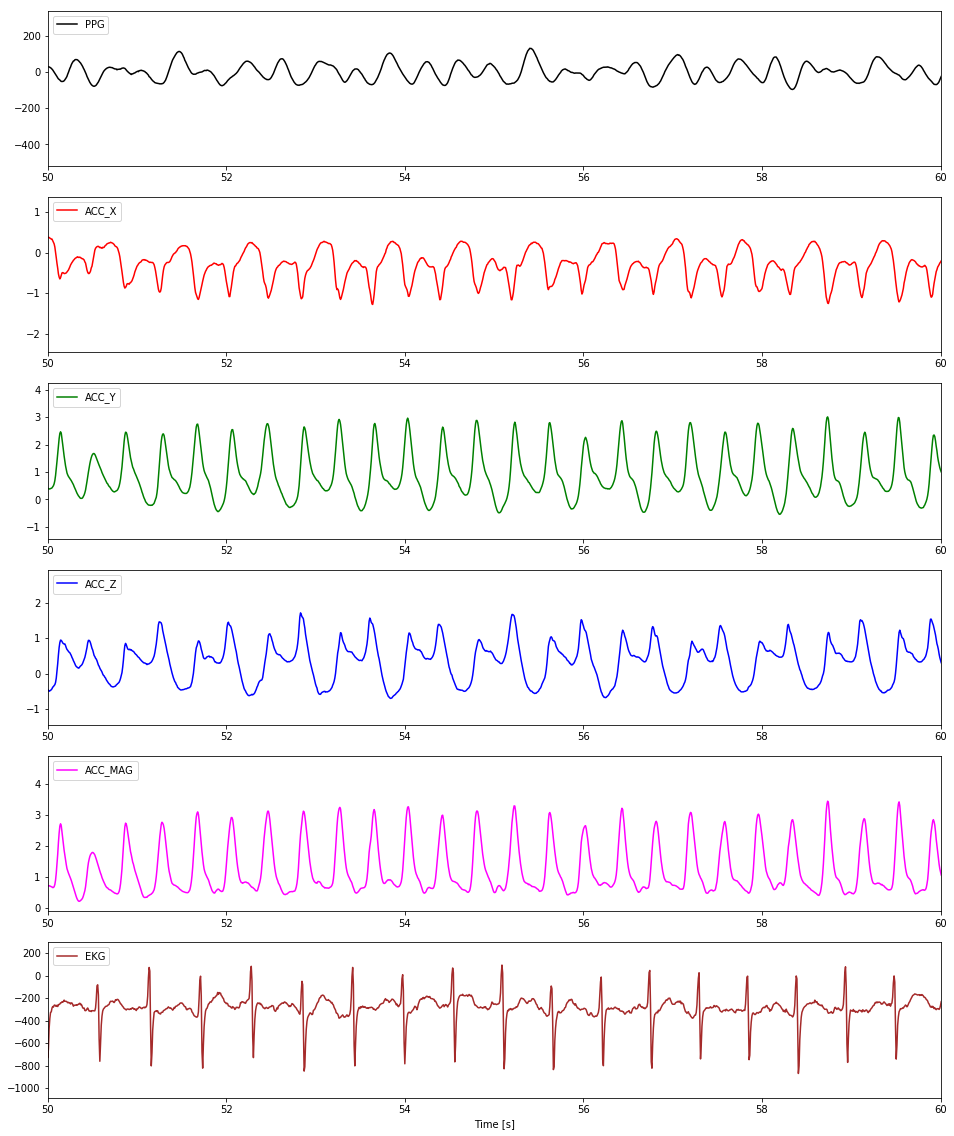

In [3]:
ppg, accx, accy, accz, ekg = ReadPlotDataSignals(data_files[2], plot_range=(50, 60))

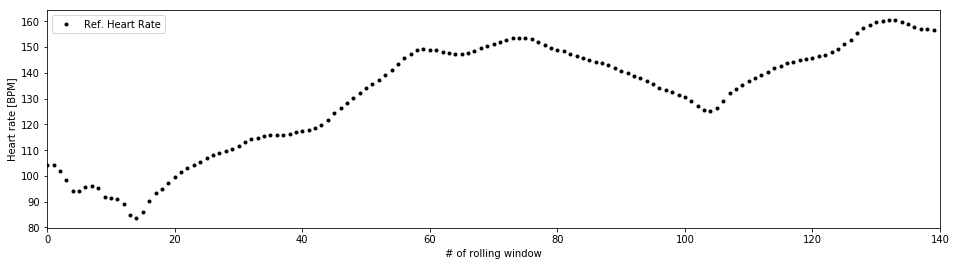

In [4]:
heart_rate_gt = ReadPlotHeartRateGT(ref_files[2])

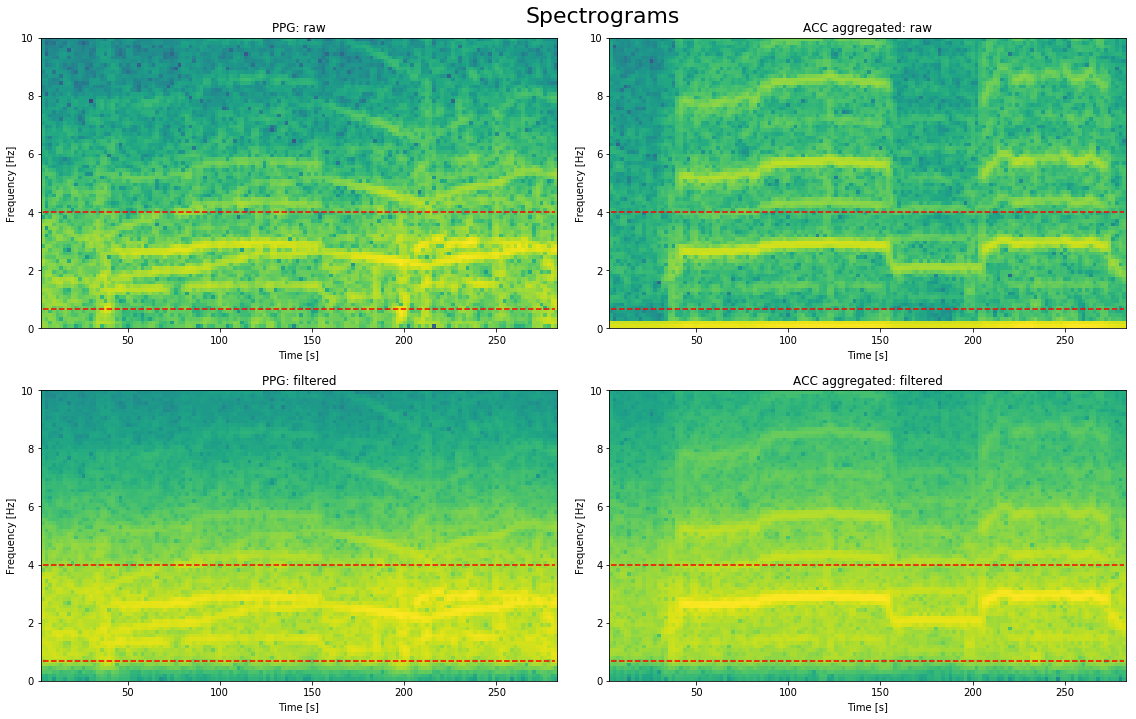

In [5]:
acc_mag = AggragateAccSignals(accx, accy, accz)
t, freqs, spectrum_ppg, spectrum_ppg_filtered, spectrum_acc, spectrum_acc_mag_filtered = ComputePlotSpectrograms(ppg, acc_mag)

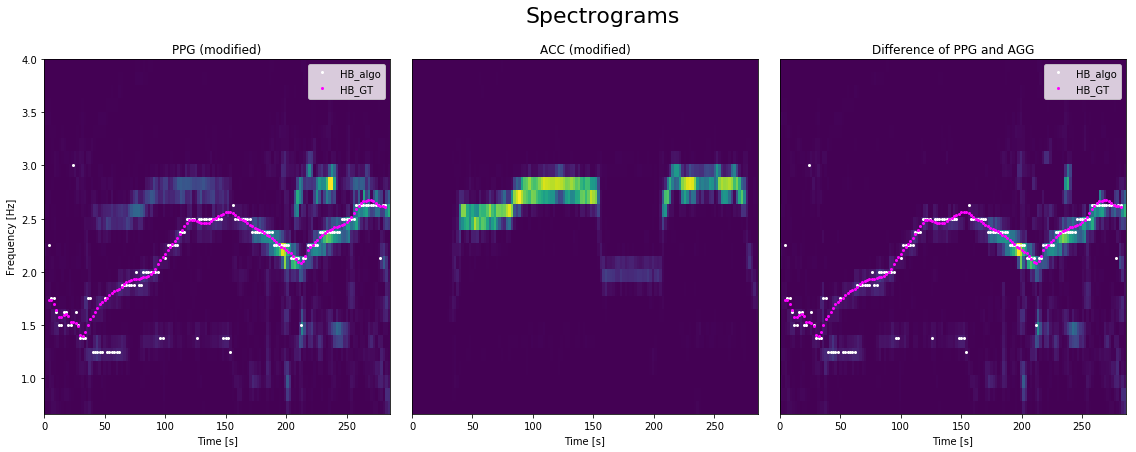

In [6]:
errors, confidence = RunPulseRateAlgorithm(data_files[2], ref_files[2])


-----
### Project Write-up

#### Code description
1. Run the first cell to load all libraries, constants and functions. <br><br>
2. Choose an option: <br>
 &ensp; - <b> High level evaluation:</b> run the cell with Evaluate() function. <br>
 &ensp; &ensp;   This loads the whole TROIKA dataset, runs the algorithm, plots the results together with the ground truth. <br>
 &ensp; &ensp; The function returns heart rate error on the training part of the Troika dataset. <br>
 &ensp; - <b> Low level evaluation:</b> use LoadTroikaDataset() function and then RunPulseRateAlgorithm(data_files[i], ref_files[i]) with i = <0, 11> <br> &ensp; &ensp; for a given pair of data & reference files.<br>
 &ensp; - <b> EDA:</b> run the cell with LoadTroikaDataset() and then you can use following functions, whose description you can find in the docstrings:<br>
 &ensp; &ensp;  ReadPlotDataSignals(data_files[i], plot_range=(t_min, t_max)) <br>
 &ensp; &ensp;  ReadPlotHeartRateGT(ref_files[i]) <br>
 &ensp; &ensp;  AggragateAccSignals(accx, accy, accz) <br>
 &ensp; &ensp;  ComputePlotSpectrograms(ppg, acc_mag) <br>
 
#### Data description
The dataset used for this algorithm is from the following publication: Z. Zhang, Z. Pi, and B.Liu's paper "TROIKA: A General Framework for Heart Rate Monitoring Using Wrist-Type Photoplethysmographic Signals During Intensive Physical Exercise.": <br>
<br>
In the study following sensors were used: <br>
 &ensp; - On a subject's wrist: A two channel photoplethysmogram (PPG) sensor with green LEDs emitting light of 515 nm. <br>
 &ensp; - On a subject's wrist: three-axis accelerometer (ACC) sensor. <br>
 &ensp; - On a subject'chest:  A EKG sensor. <br>
<br> 
All signals were recorded simultaneously from subjects aged 18 - 35 years, with a sampling frequency of 125 Hz. <br>
<br>
The signals were recorded during run on a treadmill with varying speed. There were two types of run: <br>
 &ensp; - TYPE01: Rest (30s)-> 8 km/h (1min) -> 15 km/h (1min) -> 8km/h (1min) -> 15km/h (1min) -> Rest(30s) <br>
 &ensp; - TYPE02: Rest (30s)-> 6 km/h (1min) -> 12 km/h (1min) -> 6km/h (1min) -> 12km/h (1min) -> Rest(30s) <br>
<br> 
The training dataset contains two subjects' TYPE01 run and ten subjects' TYPE02 run. Thus can be more biased towards TYPE02 run.
<br>
Study design: <br>
 &ensp; - The heart rate is to be determined from PPG sensor with the use of one channel <br>
 &ensp; - The heart rate determined from EKG sensor serves as ground truth <br>
 &ensp; - The accelerometer signals are used as aid for interpretation of PPG signal, as subjects' movements can have an influence on the reading of PPG sensor.

#### Algorithm description
The Pulse Rate algorithm works in a following way: <br>
1. Loads PPG and 3-axis accelerometer signals as well as the ground truth.
2. Aggragates the accelerometer signals and filters all signals, using bandpass filter between 40 BPM and 240 BPM.
3. Computes two spectrograms: for PPG and aggragated accelerometer signals with the use of 8s windows overlapping by 6s.
4. Cuts the spectorgrams to 40 BPM - 240 BPM range and normalizes them.
5. Subtracts the normalized accelerometer spectogram from the normalized PPG spectrogram, substitutes negative pixels with 0. 
6. Assignes the frequency having maximum amplitude to heart rate in each time window
7. Plots the normalized spectrograms and their difference with superimposed heart rate values found by the algorithm as well as those from the ground truth.
8. Calculates a confidence estimate and error for each heart rate value.<br>
<br>
<br>
Relevant aspects of the physiology: <br>
The green light emitted by PPG sensor is partially absorbed by the blood cells and partially reflected. In the senor, the reflected signal is measured. When the heart beats and the bloof flows through the wrist, there are more blood cells absorbing the signal, thus the reflected signal is lower. When the heart fills back with blood, more light is reflected. The oscillating signal is used to detect heart rate.<br>
<br> 
Description of the algorithm outputs: <br>
The algorithm returns a tuple of numpy arrays containing errors between pulse rate estimates and corresponding reference heart rates as well as confidence estimates for each pulse rate. <br>
<br>
Caveats on algorithm outputs: <br>
The confidence estimate is calculates as a sum of amplitudes around heart rate frequency within similarity range (+/- 15 BPM) divided by the sum of amplitudes of whole spectrum, expressed in %. The error is an absolute error between pulse rate estimates and corresponding reference heart rates.<br>
<br>
Common failure modes:<br>
A common failure is when the signal in PPG sensor having maximum amplitude is not related to heart beat nor to movements caught by the accelerometer. <br>

#### Algorithm performance
The performance was calualed by mean absolute arror (MAE) between between pulse rate estimates and corresponding reference heart rates at 90% availability. On the train set it amounts to 30.64, whereas on the test set to 8.42. Depending on the signal quality different errors are to be expected. Moreover different type of running intervals or different activity can have profound impact on the error.

-----
### Next Steps
You will now go to **Test Your Algorithm** to apply a unit test to confirm that your algorithm met the success criteria. 

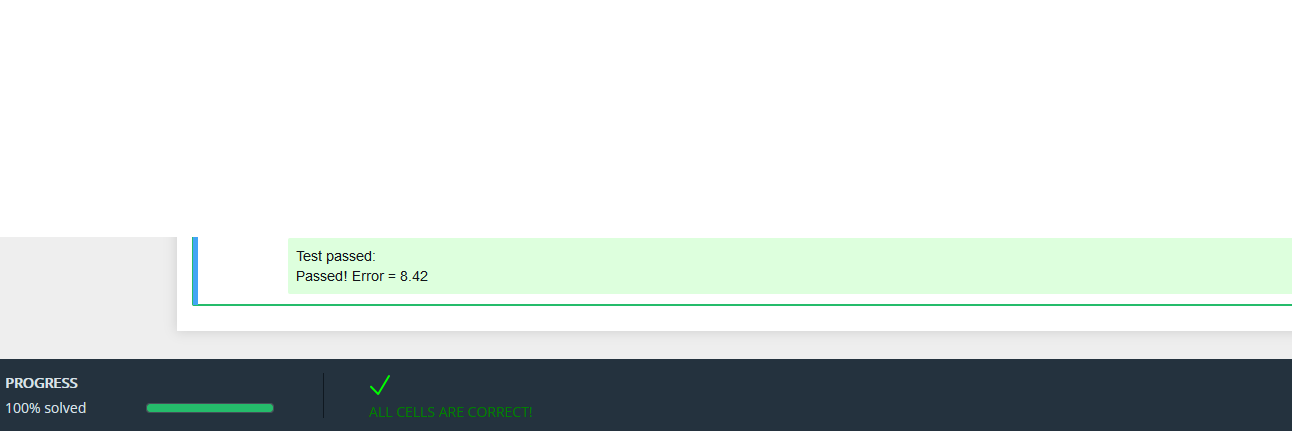